In [1]:
%matplotlib inline # This causes the graphs/plots to be displayed directly in the notebook output (inline plotting).
import openmc # Importing the module 'openmc' from Python.

In [2]:
# Definition of materials.
# Note that the temperatures are in Kelvin units.

# Air composition
air = openmc.Material(name='Air')
air.set_density('g/cm3', 0.0003922)
air.add_element('Ar', 0.01288 ,'wo')
air.add_element('N', 0.7552178 ,'wo')
air.add_element('O', 0.2317709455 ,'wo')
air.add_element('C', 0.000131254 ,'wo')
air.temperature = 1000

# Gas gap composition
helium = openmc.Material(name='Helium')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 1,'wo')
helium.temperature = 823 

# Clad composition
t91 = openmc.Material(name='T91 Steel')
t91.set_density('g/cm3', 7.7)
t91.add_element('Fe', 0.884, 'wo')
t91.add_element('Cr', 0.09, 'wo')
t91.add_element('Mo', 0.01  , 'wo')
t91.add_element('Mn', 0.006, 'wo')
t91.add_element('Si', 0.005, 'wo')
t91.add_element('V', 0.002, 'wo')
t91.add_element('Ni', 0.002, 'wo')
t91.add_element('Nb', 0.001, 'wo')
t91.temperature = 823 # The maximum clad temperature at normal operating conditions is 550°C or 823 K.

# Coolant composition 
lead = openmc.Material(name='Lead Coolant')
lead.add_element('Pb', 1)
lead.set_density('g/cm3', 10.58)
lead.temperature = 673 # The core inlet temperature is 400°C.

# Absorber material
b4c = openmc.Material(name='Boron Carbide Absorber')
b4c.add_element('B', 4, enrichment = 90.0, enrichment_target = 'B10')
b4c.add_nuclide('C12', 1)
b4c.set_density('g/cm3', 2.2)
b4c.temperature = 673


# Moderator composition
zrh = openmc.Material(name = 'Zirconium Hydride')
zrh.add_element('Zr', 1)
zrh.add_element('H', 1.6)
zrh.set_density('g/cm3', 5.66) 
zrh.temperature = 823

yh = openmc.Material(name = 'Yttrium Hydride')
yh.add_element('Y', 1)
yh.add_element('H', 2)
yh.set_density('g/cm3', 4.26) 
yh.temperature = 823

In [3]:
# Fuel composition 

UO2 = openmc.Material(name = 'Urania') # Uranium dioxide with 4.5% enrichment. 
UO2.add_element('U', 1.0, enrichment = 4.5)
UO2.add_element('O', 2.0)
UO2.set_density('g/cm3', 10.5)

PuO2 = openmc.Material(name = 'Plutonium Dioxide')
PuO2.add_nuclide('Pu238', 0.01)
PuO2.add_nuclide('Pu239', 0.659)
PuO2.add_nuclide('Pu240', 0.252)
PuO2.add_nuclide('Pu241', 0.039)
PuO2.add_nuclide('Pu242', 0.04)
PuO2.add_nuclide('O16', 2.0)
PuO2.set_density('g/cm3', 10.887)

UO2_dep = openmc.Material(name = 'Depleted Uranium') # Depleted uranium dioxide
UO2_dep.add_element('U', 1, enrichment = 0.25)
UO2_dep.add_element('O', 2.0)
UO2_dep.set_density('g/cc', 11.08)
UO2_dep.temperature = 1000

UO2_nat = openmc.Material(name = 'Natural Uranium') # Natural uranium dioxide
UO2_nat.add_element('U', 1, enrichment = 0.72)
UO2_nat.add_element('O', 2.0)
UO2_nat.set_density('g/cc', 10.97)
UO2_nat.temperature = 1000


# Minor actinide (MA) composition

MA = openmc.Material(name = 'Minor Actinides')
MA.add_nuclide('Np237', 0.562, 'wo')
MA.add_nuclide('Am241', 0.264, 'wo')
MA.add_nuclide('Am243', 0.12, 'wo')
MA.add_nuclide('Cm243', 0.0003, 'wo')
MA.add_nuclide('Cm244', 0.0511, 'wo')
MA.add_nuclide('Cm245', 0.0026, 'wo')
MA.set_density('g/cm3', 15.43)

In [4]:
# MOX fuels
MOX1 = openmc.Material.mix_materials([UO2_dep, PuO2], [0.85, 0.15], 'wo')
MOX2 = openmc.Material.mix_materials([UO2_dep, PuO2], [0.8, 0.2], 'wo')

# MOX fuels with minor actinides
MOX3 = openmc.Material.mix_materials([UO2_dep, PuO2, MA], [0.75, 0.2, 0.05], 'wo')
MOX4 = openmc.Material.mix_materials([UO2_dep, PuO2, MA], [0.7, 0.2, 0.1], 'wo')

MOX1.temperature = 1000
MOX2.temperature = 1000
MOX3.temperature = 1000
MOX4.temperature = 1000

In [5]:
# Instantiate a materials collection and export it to XML

materials_file = openmc.Materials([air, MOX1, MOX2, UO2_dep, UO2_nat, helium, t91, lead])
materials_file.export_to_xml()


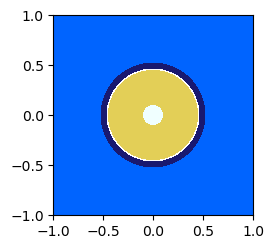

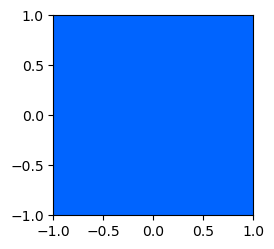

In [6]:
# Instantiate cylindrical surfaces (fuel of inner zone of the core).
# All lengths are in cm. The core design is based on the European lead-cooled demonstrator reactor ALFRED.
# The ALFRED core active height is 90 cm.

fuel_ir  = openmc.ZCylinder(r=0.10)
fuel_or  = openmc.ZCylinder(r=0.45)
clad_ir  = openmc.ZCylinder(r=0.465)
clad_or  = openmc.ZCylinder(r=0.525)

top      = openmc.ZPlane(z0=45, name='top', boundary_type = 'reflective')
bottom   = openmc.ZPlane(z0=-45, name='bottom', boundary_type = 'reflective')


# Instantiate cells and fill with materials
hole = openmc.Cell(name='Hole', region = -fuel_ir, fill = air)
fuel_iz = openmc.Cell(name='Inner Zone Fuel', region  = +fuel_ir & -fuel_or, fill = MOX1) # iz refers to inner zone.
gap = openmc.Cell(name='Gap', region  = +fuel_or & -clad_ir, fill = helium)
clad = openmc.Cell(name='Cladding', region = +clad_ir & -clad_or, fill = t91)
coolant = openmc.Cell(name='Coolant', region = +clad_or, fill = lead)


# Instantiate inner zone fuel universe
f_iz = openmc.Universe(cells=[hole, fuel_iz, gap, clad, coolant])
f_iz.plot(width=(2.0,2.0), color_by = 'material',
       colors = {air:(240,255,255), t91:(25,25,112), helium:(255,255,255), lead:(0,100,255), MOX1:(227,207,87),
                 MOX2:(255,51,51)})

# Instantiate coolant universe
lead_cell = openmc.Cell(fill=lead)
lead_univ = openmc.Universe(cells=[lead_cell])
lead_univ.plot(width=(2.0,2.0), color_by = 'material', colors = {lead:(0,100,255)})


HexLattice
	ID             =	3
	Name           =	
	Orientation    =	y
	# Rings        =	7
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(1.384,)
	Outer          =	2
	Universes      
      1
     1 1
    1 1 1
   1 1 1 1
  1 1 1 1 1
 1 1 1 1 1 1
1 1 1 1 1 1 1
 1 1 1 1 1 1
1 1 1 1 1 1 1
 1 1 1 1 1 1
1 1 1 1 1 1 1
 1 1 1 1 1 1
1 1 1 1 1 1 1
 1 1 1 1 1 1
1 1 1 1 1 1 1
 1 1 1 1 1 1
1 1 1 1 1 1 1
 1 1 1 1 1 1
1 1 1 1 1 1 1
 1 1 1 1 1 1
  1 1 1 1 1
   1 1 1 1
    1 1 1
     1 1
      1


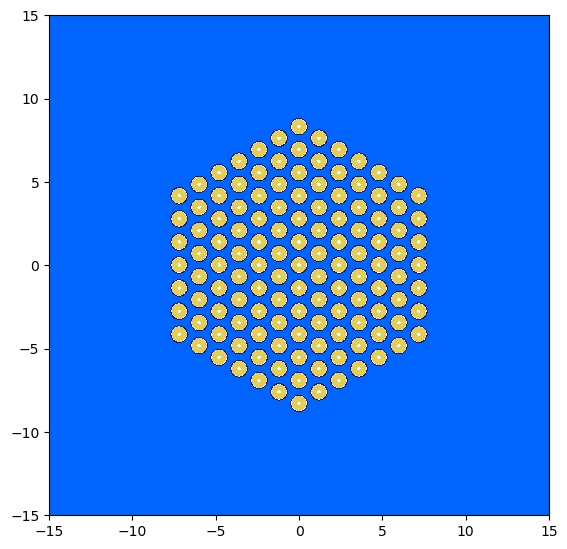

In [7]:
# Fuel assembly of inner zone

fa_iz = openmc.HexLattice()
fa_iz.center = (0., 0.)
fa_iz.pitch = (1.384,)
fa_iz.outer = lead_univ
fa_iz.orientation = 'y'

outer_ring = [f_iz]*36

ring_1 = [f_iz]*30

ring_2 = [f_iz]*24

ring_3 = [f_iz]*18

ring_4 = [f_iz]*12

ring_5 = [f_iz]*6

inner_ring = [f_iz]

fa_iz.universes = [outer_ring,
                     ring_1,
                     ring_2,
                     ring_3,
                     ring_4,
                     ring_5,
                     inner_ring]
print(fa_iz)

# Create the prism that will contain the lattice
outer_in_surface = openmc.model.hexagonal_prism(edge_length=7*1.384, orientation='y')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
main_in_assembly = openmc.Cell(fill=fa_iz, region=outer_in_surface & -top & +bottom)

# Fill a cell with a material that will surround the lattice
out_in_assembly  = openmc.Cell(fill=lead, region=~outer_in_surface & -top & +bottom)

# Create a universe that contains both 
main_in_u = openmc.Universe(cells=[main_in_assembly, out_in_assembly])

# Plot the universe
main_in_u.plot(origin = (0,0,0), pixels=(500, 500), width = (30.,30.), color_by = 'material',
               colors = {air:(240,255,255), t91:(25,25,112), helium:(255,255,255), lead:(0,100,255),
                         MOX1:(227,207,87), MOX2:(255,51,51)})


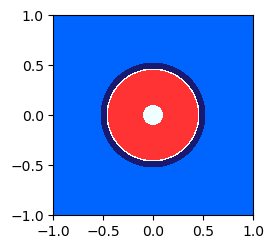

In [8]:
# Instantiate cylindrical surfaces (fuel of outer zone of the core)


fuel_ir  = openmc.ZCylinder(r=0.10)
fuel_or  = openmc.ZCylinder(r=0.45)
clad_ir  = openmc.ZCylinder(r=0.465)
clad_or  = openmc.ZCylinder(r=0.525)

top      = openmc.ZPlane(z0=45, name='top', boundary_type = 'reflective')
bottom   = openmc.ZPlane(z0=-45, name='bottom', boundary_type = 'reflective')


# Instantiate cells and fill with materials
hole = openmc.Cell(name='Hole', region = -fuel_ir, fill = air)
fuel_oz = openmc.Cell(name='Outer Zone Fuel', region  = +fuel_ir & -fuel_or , fill = MOX2)
gap = openmc.Cell(name='Gap', region  = +fuel_or & -clad_ir, fill = helium)
clad = openmc.Cell(name='Cladding', region = +clad_ir & -clad_or, fill = t91)
coolant = openmc.Cell(name='Coolant', region = +clad_or, fill = lead)


# Instantiate outer zone fuel universe
f_oz = openmc.Universe(cells=[hole, fuel_oz, gap, clad, coolant])
f_oz.plot(width=(2.0,2.0), color_by = 'material', colors = {air:(240,255,255), t91:(25,25,112), helium:(255,255,255),
                                                            lead:(0,100,255), MOX1:(227,207,87), MOX2:(255,51,51)})


HexLattice
	ID             =	6
	Name           =	
	Orientation    =	y
	# Rings        =	7
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(1.384,)
	Outer          =	2
	Universes      
      5
     5 5
    5 5 5
   5 5 5 5
  5 5 5 5 5
 5 5 5 5 5 5
5 5 5 5 5 5 5
 5 5 5 5 5 5
5 5 5 5 5 5 5
 5 5 5 5 5 5
5 5 5 5 5 5 5
 5 5 5 5 5 5
5 5 5 5 5 5 5
 5 5 5 5 5 5
5 5 5 5 5 5 5
 5 5 5 5 5 5
5 5 5 5 5 5 5
 5 5 5 5 5 5
5 5 5 5 5 5 5
 5 5 5 5 5 5
  5 5 5 5 5
   5 5 5 5
    5 5 5
     5 5
      5


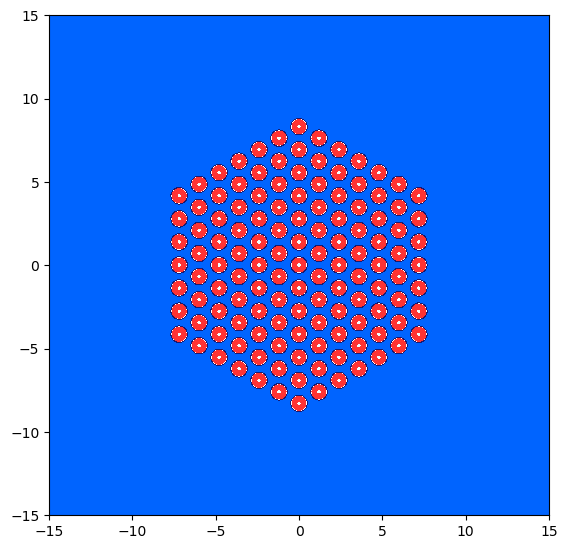

In [9]:
# Fuel assembly of the outer zone

fa_oz = openmc.HexLattice()
fa_oz.center = (0., 0.)
fa_oz.pitch = (1.384,)
fa_oz.outer = lead_univ
fa_oz.orientation = 'y'

outer_ring = [f_oz]*36

ring_1 = [f_oz]*30

ring_2 = [f_oz]*24

ring_3 = [f_oz]*18

ring_4 = [f_oz]*12

ring_5 = [f_oz]*6

inner_ring = [f_oz]

fa_oz.universes = [outer_ring,
                     ring_1,
                     ring_2,
                     ring_3,
                     ring_4,
                     ring_5,
                     inner_ring]
print(fa_oz)

# Create the prism that will contain the lattice
outer_out_surface = openmc.model.hexagonal_prism(edge_length=7*1.384, orientation='y')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
main_out_assembly = openmc.Cell(fill=fa_oz, region=outer_out_surface)

# Fill a cell with a material that will surround the lattice
out_out_assembly  = openmc.Cell(fill=lead, region=~outer_out_surface)

# Create a universe that contains both 
main_out_u = openmc.Universe(cells=[main_out_assembly, out_out_assembly])

# Plot the universe
main_out_u.plot(origin = (0,0,0), pixels=(500, 500), width = (30.,30.), color_by = 'material',
                colors = {air:(240,255,255), t91:(25,25,112), helium:(255,255,255), lead:(0,100,255),
                          MOX1:(227,207,87), MOX2:(255,51,51)})


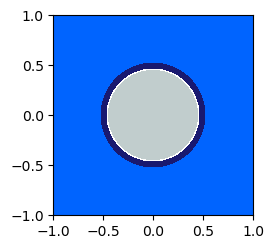

In [10]:
# Instantiate cylindrical surfaces (blanket zone)


fuel_or  = openmc.ZCylinder(r=0.45)
clad_ir  = openmc.ZCylinder(r=0.465)
clad_or  = openmc.ZCylinder(r=0.525)

top      = openmc.ZPlane(z0=45, name='top', boundary_type = 'reflective')
bottom   = openmc.ZPlane(z0=-45, name='bottom', boundary_type = 'reflective')


# Instantiate cells and fill with materials
fuel_b = openmc.Cell(name='Inner Zone Fuel', region  = -fuel_or, fill = UO2_dep)
gap = openmc.Cell(name='Gap', region  = +fuel_or & -clad_ir, fill = helium)
clad = openmc.Cell(name='Cladding', region = +clad_ir & -clad_or, fill = t91)
coolant = openmc.Cell(name='Coolant', region = +clad_or, fill = lead)


# Instantiate blanket fuel universe
f_b = openmc.Universe(cells=[fuel_b, gap, clad, coolant])
f_b.plot(width=(2.0,2.0), color_by = 'material',
         colors = {air:(240,255,255), t91:(25,25,112), helium:(255,255,255), lead:(0,100,255), UO2_dep:(193,205,205),
                          MOX1:(227,207,87), MOX2:(255,51,51)})


HexLattice
	ID             =	9
	Name           =	
	Orientation    =	y
	# Rings        =	7
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(1.384,)
	Outer          =	2
	Universes      
      8
     8 8
    8 8 8
   8 8 8 8
  8 8 8 8 8
 8 8 8 8 8 8
8 8 8 8 8 8 8
 8 8 8 8 8 8
8 8 8 8 8 8 8
 8 8 8 8 8 8
8 8 8 8 8 8 8
 8 8 8 8 8 8
8 8 8 8 8 8 8
 8 8 8 8 8 8
8 8 8 8 8 8 8
 8 8 8 8 8 8
8 8 8 8 8 8 8
 8 8 8 8 8 8
8 8 8 8 8 8 8
 8 8 8 8 8 8
  8 8 8 8 8
   8 8 8 8
    8 8 8
     8 8
      8


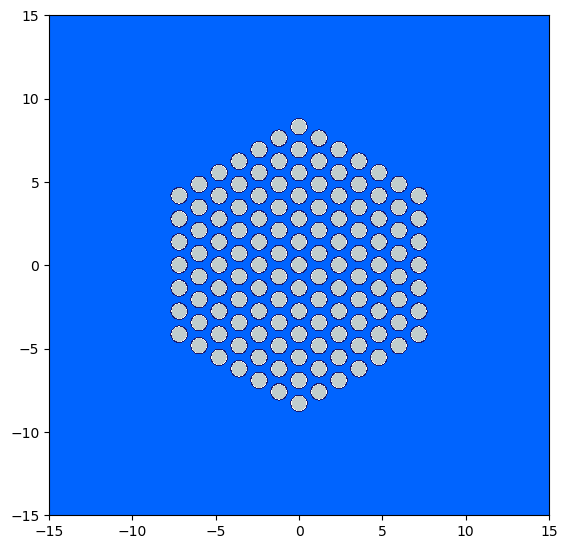

In [11]:
# Blanket assembly 

ba = openmc.HexLattice()
ba.center = (0., 0.)
ba.pitch = (1.384,)
ba.outer = lead_univ
ba.orientation = 'y'

outer_ring = [f_b]*36

ring_1 = [f_b]*30

ring_2 = [f_b]*24

ring_3 = [f_b]*18

ring_4 = [f_b]*12

ring_5 = [f_b]*6

inner_ring = [f_b]

ba.universes = [outer_ring,
                     ring_1,
                     ring_2,
                     ring_3,
                     ring_4,
                     ring_5,
                     inner_ring]
print(ba)

# Create the prism that will contain the lattice
outer_out_surface = openmc.model.hexagonal_prism(edge_length=7*1.384, orientation='y')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
main_out_assembly = openmc.Cell(fill=ba, region=outer_out_surface)

# Fill a cell with a material that will surround the lattice
out_out_assembly  = openmc.Cell(fill=lead, region=~outer_out_surface)

# Create a universe that contains both 
ba_u = openmc.Universe(cells=[main_out_assembly, out_out_assembly])

# Plot the universe
ba_u.plot(origin = (0,0,0), pixels=(500, 500), width = (30.,30.), color_by = 'material',
              colors = {air:(240,255,255), t91:(25,25,112), helium:(255,255,255), lead:(0,100,255), UO2_dep:(193,205,205),
                          MOX1:(227,207,87), MOX2:(255,51,51)})


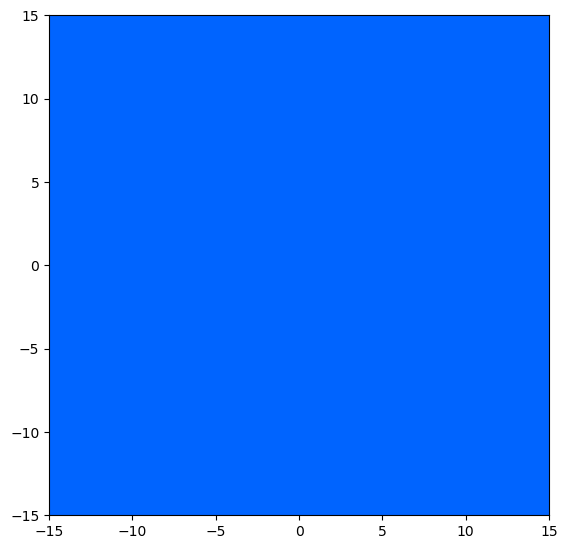

In [12]:
# Create a hexagonal lead assembly

lead_assembly = openmc.model.hexagonal_prism(edge_length=7*1.384, orientation='x')
la_cell = openmc.Cell(fill=lead, region=lead_assembly)
out_la_cell  = openmc.Cell(fill=lead, region=~lead_assembly)
lead_u = openmc.Universe(cells=[la_cell, out_la_cell])

lead_u.plot(origin = (0,0,0), pixels=(500, 500), width = (30.,30.), color_by = 'material',
            colors = {air:(240,255,255), t91:(25,25,112), helium:(255,255,255), lead:(0,100,255),
                      UO2_dep:(193,205,205), MOX1:(227,207,87), MOX2:(255,51,51)})


In [13]:
# We have all the required types of assemblies created.
# We can now make the entire reactor core by creating a lattice that is filled with the assemblies.


# Define the core lattice

core_lat = openmc.HexLattice(name='core')
core_lat.center = (0., 0.)
core_lat.pitch = (11*1.384,)
core_lat.outer = lead_univ
core_lat.orientation = 'x'

# Create rings of fuel universes that will fill the lattice

outer_ring = [lead_u, lead_u, lead_u, ba_u, ba_u, ba_u, ba_u, ba_u, lead_u, lead_u]*6

ring_9 = [ba_u]*9 + [lead_u] + [ba_u]*8 + [lead_u] + [ba_u]*17 + [lead_u] + [ba_u]*8 + [lead_u] + [ba_u]*8 

ring_8 = [ba_u, ba_u, ba_u, main_out_u, main_out_u, main_out_u, ba_u, ba_u]*6

ring_7 = [main_out_u, main_out_u, main_out_u, main_out_u, main_out_u, main_out_u, main_out_u]*6

ring_6 = [main_out_u, main_out_u, lead_u, main_out_u, lead_u, main_out_u]*6

ring_5 = [main_out_u, main_out_u, main_out_u, main_out_u, main_out_u]*6

ring_4 = [main_in_u]*24

ring_3 = [main_in_u]*18

ring_2 = [lead_u, main_in_u, main_in_u]*4

ring_1 = [main_in_u]*6

inner_ring = [main_in_u]

core_lat.universes = [outer_ring,
                      ring_9,
                      ring_8,
                      ring_7,
                      ring_6,
                      ring_5,
                      ring_4,
                      ring_3,
                      ring_2,
                      ring_1,
                      inner_ring]
print(core_lat)


HexLattice
	ID             =	12
	Name           =	core
	Orientation    =	x
	# Rings        =	11
	# Axial        =	None
	Center         =	(0.0, 0.0)
	Pitch          =	(15.223999999999998,)
	Outer          =	2
	Universes      
                    11  11  11  10  10  10  10  10  11  11  11
                  11  11  10  10  10  10  10  10  10  10  11  11
                11  10  10  10  10  7   7   7   10  10  10  10  11
              10  10  10  7   7   7   7   7   7   7   7   10  10  10
            10  10  10  7   7   7   11  7   11  7   7   7   10  10  10
          10  10  7   7   7   7   7   7   7   7   7   7   7   7   10  10
        10  10  7   7   11  7   4   4   4   4   4   7   11  7   7   10  10
      10  10  7   7   7   7   4   4   4   4   4   4   7   7   7   7   10  10
    11  10  10  7   11  7   4   4   4   11  4   4   4   7   11  7   10  10  11
  11  10  10  7   7   7   4   4   4   4   4   4   4   4   7   7   7   10  10  11
11  10  10  7   7   7   4   4   11  4   4   4   11  4  

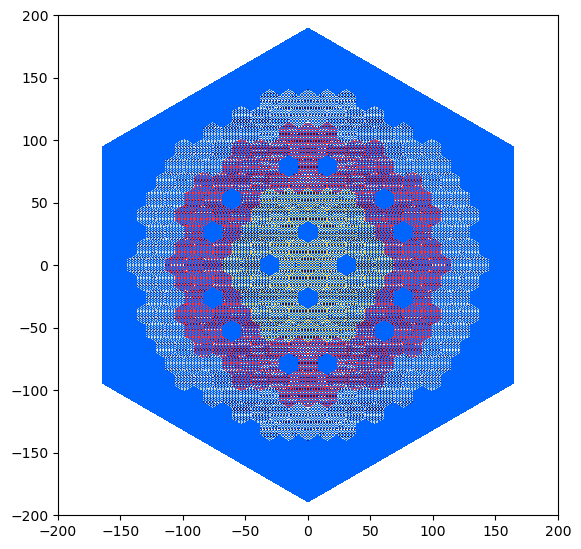

In [14]:

# Create the prism that will contain the lattice
outer_core_surface = openmc.model.hexagonal_prism(edge_length=190, boundary_type='reflective')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
core = openmc.Cell(fill=core_lat, region=outer_core_surface & -top & +bottom)

# Create a universe that contains the lattice
main_u = openmc.Universe(cells=[core]) 

main_u.plot(origin = (0,0,0), pixels=(500, 500), width = (400.,400.), color_by = 'material',
                    colors = {air:(240,255,255), t91:(25,25,112), helium:(255,255,255), lead:(0,100,255),
                      UO2_dep:(193,205,205), MOX1:(227,207,87), MOX2:(255,51,51)})


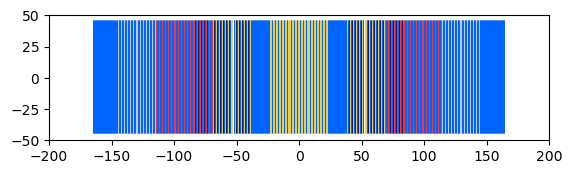

In [15]:
main_u.plot(origin = (0,0,0), pixels=(500, 500), width = (400.,100.), color_by = 'material', basis = 'xz',
                    colors = {air:(240,255,255), t91:(25,25,112), helium:(255,255,255), lead:(0,100,255),
                      UO2_dep:(193,205,205), MOX1:(227,207,87), MOX2:(255,51,51)})


In [16]:
geometry = openmc.Geometry(main_u)
geometry.export_to_xml()

In [17]:
# OpenMC simulation parameters
batches = 10
inactive = 5
particles = 10000

In [18]:
##############################################################################
#                   Exporting to OpenMC settings.xml file                    #
##############################################################################

# Instantiate a Settings object, set all runtime parameters, and export to XML
settings_file = openmc.Settings()
settings_file.temperature = {'method':'interpolation'}
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.energy_mode = 'continuous-energy'

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-150, -150, -50, 150, 150, 50]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.Source(space=uniform_dist)



settings_file.export_to_xml()

In [19]:
# openmc.run()